<p style="font-size: 30px">Fix policy in Q-Learning & Policy Iteration</p>

This script is used to compare the tabular Q-Learning and policy iteration with the optimal policy from dual LP.

**Logs**

*Tabular Q Learning*
- [x] Results from q-learning does not converge and are away from the optimal. -> PI
- [x] Tried decaying learning rate & decaying epsilon. Works a little better.
- [ ] GGF-QL

*Policy Iteration*
- [x] PI converges and gives better results
- [ ] GGF-PI

In [1]:
# a temporary solution, run twice to set the current path as '../Fair-RL/src'
%cd ..

/Users/xiaohui/SpyderProjects/PhD/Fair-RL/src


In [17]:
# used to auto-reload imported module after making modification inside .py files
%load_ext autoreload
%autoreload 2

In [2]:
import argparse

from env.mrp_env import MachineReplace
from experiments.configs.config_shared import prs_parser_setup
import seaborn as sns
import numpy as np


# configuration parameters
prs = argparse.ArgumentParser(
    formatter_class=argparse.ArgumentDefaultsHelpFormatter,
    description="""Tabular Q Learning.""",
)
prs = prs_parser_setup(prs)
args, _ = prs.parse_known_args()

# check parameters
args

Namespace(ggi=False, n_action=2, n_group=3, n_state=3, weight=2)

# Dual LP
Optimal solutions from dual LP are given as:

In [21]:
import numpy as np

# Build data
from utils.mrp_lp import MRPData

weight_coef = np.array([1 / (2 ** i) for i in range(args.n_group)])
data_mrp = MRPData(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    weight=weight_coef,
)  # TODO: not by default

# results for ggf dual
from solver.ggf_dual import build_ggf, extract_results, solve_ggf

# Build t1he GGF model
ggf_model_lp = build_ggf(data=data_mrp)
# Solve the GGF model
results_lp, ggf_model_lp = solve_ggf(model=ggf_model_lp)
# Extract the results
extract_results(model=ggf_model_lp, data=data_mrp)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 36 rows, 114 columns and 1592 nonzeros
Model fingerprint: 0xcfb725c3
Coefficient statistics:
  Matrix range     [1e-01, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve time: 0.00s
Presolved: 36 rows, 114 columns, 1592 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.259259e+00   0.000000e+00      0s
      60    4.1508739e+01   0.000000e+00   0.000000e+00      0s

Solved in 60 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.150873891e+01
x((0, 0, 0), 0): 0.08962194783040893
x((0, 0, 1), 0): 0.065000707827664
x((0, 0, 2), 0): 0.04778972520908004
x((0, 1, 0), 0): 0.065000707827664
x((0, 1, 1), 0): 0.04702182841440925
x((0, 1, 2), 3): 0

[41.50873891260395, 41.508738912603974, 41.508738912603974]

# Q-learning

In [19]:
from algorithms.tabular_q import QAgent, run_tabular_q

In [21]:
# initialize the MRP environment
env = MachineReplace(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    init_state=0,
    ggi=args.ggi,
)

tabular_q_policy, episode_rewards = run_tabular_q(
    env=env, num_episodes=500, len_episode=1500, alpha=0.1, epsilon=0.2, decaying_factor=1.0, gamma=0.90
)

Episode: 0; Running reward: 1514.8
Episode: 20; Running reward: 1903.5
Episode: 40; Running reward: 1833.4
Episode: 60; Running reward: 1843.9
Episode: 80; Running reward: 1867.3
Episode: 100; Running reward: 1841.3
Episode: 120; Running reward: 1875.0
Episode: 140; Running reward: 1828.6
Episode: 160; Running reward: 2006.1
Episode: 180; Running reward: 1834.8
Episode: 200; Running reward: 1831.2
Episode: 220; Running reward: 1880.2
Episode: 240; Running reward: 1808.5
Episode: 260; Running reward: 1850.4
Episode: 280; Running reward: 1950.0
Episode: 300; Running reward: 1780.7
Episode: 320; Running reward: 1890.4
Episode: 340; Running reward: 1893.7
Episode: 360; Running reward: 1912.1
Episode: 380; Running reward: 1899.3
Episode: 400; Running reward: 2038.1
Episode: 420; Running reward: 1924.4
Episode: 440; Running reward: 1891.1
Episode: 460; Running reward: 1768.4
Episode: 480; Running reward: 1917.6


<AxesSubplot:>

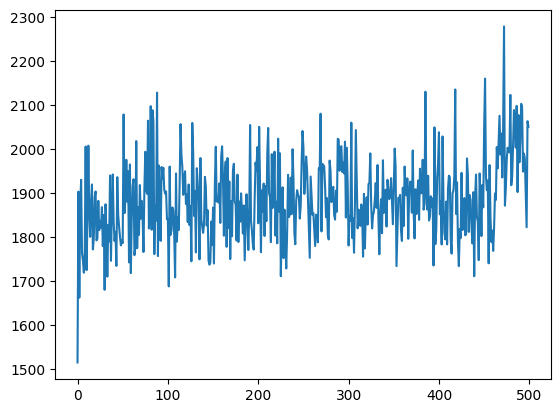

In [22]:
sns.lineplot(episode_rewards)

Next, we fix the policy from q-learning and solve.

In [7]:
import numpy as np

# results for fixing the RL policy
from solver.fix_policy import (
    build_ggf_fix,
    extract_results as extract_results_fix,
    solve_ggf_fix,
)

# Build data
from utils.mrp_lp import MRPData

weight_coef = np.array([1 / (2 ** i) for i in range(args.n_group)])
data_mrp = MRPData(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    weight=weight_coef,
)  # TODO: not by default

model = build_ggf_fix(data_mrp, tabular_q_policy)
# Solve the GGF model
results, ggf_model = solve_ggf_fix(model=model)
extract_results_fix(model=ggf_model, data=data_mrp, policy_rl=tabular_q_policy)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 114 columns and 1754 nonzeros
Model fingerprint: 0x48fd1f6a
Coefficient statistics:
  Matrix range     [1e-01, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 135 rows and 108 columns
Presolve time: 0.01s
Presolved: 9 rows, 6 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.068135e+02   0.000000e+00      0s
       5    3.2294786e+02   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.229478613e+02
x((0, 0, 0), 0): 0.4039332004193236
x((0, 0, 1), 2): 0.3773132076765496
x((0, 0, 2), 0): 0.3703703703703704
x((0, 1, 0), 0): 0.5117155886467053
x((0, 1, 1), 0): 0

[720.0, 920.0, 720.0]

In [23]:
import numpy as np

# results for fixing the RL policy
from solver.fix_policy import (
    build_ggf_fix,
    extract_results as extract_results_fix,
    solve_ggf_fix,
)

# Build data
from utils.mrp_lp import MRPData

weight_coef = np.array([1 / (2 ** i) for i in range(args.n_group)])
data_mrp = MRPData(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    weight=weight_coef,
)  # TODO: not by default

model = build_ggf_fix(data_mrp, tabular_q_policy)
# Solve the GGF model
results, ggf_model = solve_ggf_fix(model=model)
extract_results_fix(model=ggf_model, data=data_mrp, policy_rl=tabular_q_policy)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 114 columns and 1754 nonzeros
Model fingerprint: 0x5e984dd4
Coefficient statistics:
  Matrix range     [1e-01, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 135 rows and 108 columns
Presolve time: 0.02s
Presolved: 9 rows, 6 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.490097e+02   0.000000e+00      0s
       5    3.4669052e+02   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.03 seconds (0.00 work units)
Optimal objective  3.466905181e+02
x((0, 0, 0), 0): 0.39389777509736235
x((0, 0, 1), 0): 0.4772870925932074
x((0, 0, 2), 0): 0.5930607873088801
x((0, 1, 0), 3): 0.3783427328471177
x((0, 1, 1), 3): 

[720.0, 720.0, 1000.0]

# Policy Iteration

not a ggf version, but closer to the optimal (LP Optimal objective  4.150873891e+01 vs. PI Optimal objective  4.271292196e+01)

**Policy Iteration**

1. Policy Evaluation: $V^\pi (s) \leftarrow r({s}, \pi({s})) + \gamma E_{{s}^\prime \sim p({s}^\prime | {s}, \pi({s}))}[V^\pi({s}^\prime)]$
2. Policy Improvement: $\pi \leftarrow \pi^\prime$, where
    
    $\pi^\prime({a}|{s})$ = 1 if ${a} = \arg \max_{{a}} Q^\pi({s}, {a})$ and 0 otherwise

In [23]:
"""This script is used to run policy iteration algorithm."""

import numpy as np

from utils.mrp_lp import MRPData


class PIAgent:
    def __init__(self, params, gamma=0.99, theta=1e-10):
        self.mrp_data = MRPData(
            n_group=params["n_group"],
            n_state=params["n_state"],
            n_action=params["n_action"],
            weight=None
        )
        self.ggi = params["ggi"]
        self.gamma = gamma  # discount factor
        self.theta = theta  # threshold to stop policy evaluation
        self.n_state = len(self.mrp_data.idx_list_s)
        self.n_action = len(self.mrp_data.idx_list_a)

    def policy_evaluation(self, pi, ggi):
        if not self.ggi:
            prev_V = np.zeros(self.n_state, dtype=np.float64)
        while True:
            V = np.zeros(self.n_state, dtype=np.float64)
            for s in range(self.n_state):
                next_state_prob = self.mrp_data.bigT[s, :, pi(s)]
                reward = sum(-self.mrp_data.bigC[s, pi(s), :] + 110)
                V[s] += reward + self.gamma * np.dot(prev_V, next_state_prob)
            if np.max(np.abs(prev_V - V)) < self.theta:
                break
            prev_V = V.copy()
        return V

    def policy_improvement(self, V, ggi):
        Q = np.zeros((self.n_state, self.n_action), dtype=np.float64)
        for s in range(self.n_state):
            for a in range(self.n_action):
                next_state_prob = self.mrp_data.bigT[s, :, a]
                reward = sum(-self.mrp_data.bigC[s, a, :] + 110)
                Q[s][a] += reward + self.gamma * np.dot(V, next_state_prob)
        new_pi = lambda s: {s: a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
        return new_pi

    def run_policy_iteration(self):
        init_actions = [0 for s in range(self.n_state)]
        pi = lambda s: {s: 0 for s, a in enumerate(init_actions)}[s]
        while True:
            old_pi = {s: pi(s) for s in range(self.n_state)}
            if not self.ggi:
                Vs = self.policy_evaluation(pi)
                pi = self.policy_improvement(Vs)
            else:
                # TODO: add GGF policy evaluation and improvement
                Vs = self.policy_evaluation(pi)
                pi = self.policy_improvement(Vs)
            # convergence check
            if old_pi == {s: pi(s) for s in range(self.n_state)}:
                break
        return Vs, pi


# initialize the environment
params = {"n_group": 3, "n_state": 3, "n_action": 2, "ggi": False}
# initialize the agent
policy_agent = PIAgent(params, gamma=0.99, theta=1e-10)
# run policy iteration
V, pi = policy_agent.run_policy_iteration()
policy = {s: pi(s) for s in range(policy_agent.n_state)}

# results for fixing the RL policy
from solver.fix_policy import (
    build_ggf_fix,
    extract_results as extract_results_fix,
    solve_ggf_fix,
)

model = build_ggf_fix(policy_agent.mrp_data, policy)
# Solve the GGF model
results, ggf_model = solve_ggf_fix(model=model)
extract_results_fix(model=ggf_model, data=policy_agent.mrp_data, policy_rl=policy)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 114 columns and 1754 nonzeros
Model fingerprint: 0x3cdd362e
Coefficient statistics:
  Matrix range     [1e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 135 rows and 108 columns
Presolve time: 0.01s
Presolved: 9 rows, 6 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.281388e+02   0.000000e+00      0s
       5    4.2712922e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.271292196e+01
x((0, 0, 0), 0): 0.08731825744639655
x((0, 0, 1), 0): 0.058942855336372155
x((0, 0, 2), 3): 0.037037037037037035
x((0, 1, 0), 0): 0.058942855336372155
x((0, 1, 1)

[1260.0, 1080.0, 960.0]

## GGF-PI

1. Multi-Objective Policy Evaluation:
    
    We use the multi-objective version of Bellman equation:
    
    $\mathbf{V}^\pi(s) \leftarrow \mathbf{r}(s, \pi(s)) + \gamma E_{s^\prime \sim p(s^\prime | s, \pi(s))}\left[\mathbf{V}^\pi(s^\prime)\right]$,
    
    where $\mathbf{r}(s, \pi(s))$ is a vector of rewards for each objective obtained from the environment.
    
2. Multi-Objective Policy Improvement: $\pi(s) \leftarrow \pi^\prime(s)$, where
    
    $\pi^\prime({a}|{s})$ = 1 if ${a} = \arg \max_{a} \mathbf{w}^T \mathbf{Q}_{\sigma}^\pi({s}, {a})$ and 0 otherwise. $\sigma$ is an ascending permutation.
    
    Here, $\mathbf{Q}^\pi(s, a) = \mathbf r(s, a) + \gamma E_{s^\prime \sim p(s^\prime | s, a)}\left[\mathbf{V}^\pi(s^\prime)\right]$

In [16]:
"""This script is used to run policy iteration algorithm."""

import numpy as np

from utils.mrp_lp import MRPData


class PIAgent:
    def __init__(self, params, gamma=0.99, theta=1e-10):
        self.mrp_data = MRPData(
            n_group=params["n_group"],
            n_state=params["n_state"],
            n_action=params["n_action"],
            weight=None
        )
        self.ggi = params["ggi"]
        self.gamma = gamma  # discount factor
        self.theta = theta  # threshold to stop policy evaluation
        self.n_state = len(self.mrp_data.idx_list_s)
        self.n_action = len(self.mrp_data.idx_list_a)
        self.n_group = self.mrp_data.n_group

    def policy_evaluation(self, pi):
        if not self.ggi:
            prev_V = np.zeros(self.n_state, dtype=np.float64)
            while True:
                V = np.zeros(self.n_state, dtype=np.float64)
                for s in range(self.n_state):
                    next_state_prob = self.mrp_data.bigT[s, :, pi(s)]
                    reward = sum(-self.mrp_data.bigC[s, pi(s), :] + 110)
                    V[s] += reward + self.gamma * np.dot(prev_V, next_state_prob)
                if np.max(np.abs(prev_V - V)) < self.theta:
                    break
                prev_V = V.copy()
        else:
            prev_V = np.zeros((self.n_state, self.n_group), dtype=np.float64)
            while True:
                V = np.zeros((self.n_state, self.n_group), dtype=np.float64)
                for s in range(self.n_state):
                    next_state_prob = self.mrp_data.bigT[s, :, pi(s)]
                    reward = -self.mrp_data.bigC[s, pi(s), :] + 110
                    for g in range(self.n_group):
                        V[s, g] += reward[g] + self.gamma * np.dot(prev_V[:,g], next_state_prob)
                if np.max(np.abs(prev_V - V)) < self.theta:
                    break
                prev_V = V.copy()
        return V

    def policy_improvement(self, V):
        Q = np.zeros((self.n_state, self.n_action), dtype=np.float64)
        if not self.ggi:
            for s in range(self.n_state):
                for a in range(self.n_action):
                    next_state_prob = self.mrp_data.bigT[s, :, a]
                    reward = sum(-self.mrp_data.bigC[s, a, :] + 110)
                    Q[s][a] += reward + self.gamma * np.dot(V, next_state_prob)
            new_pi = lambda s: {s: a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
        else:
            Qn = np.zeros(self.n_group, dtype=np.float64)
            for s in range(self.n_state):
                for a in range(self.n_action):
                    next_state_prob = self.mrp_data.bigT[s, :, a]
                    reward = -self.mrp_data.bigC[s, a, :] + 110
                    for g in range(self.n_group):
                        Qn[g] += reward[g] + self.gamma * np.dot(V[:, g], next_state_prob)
                    Q[s][a] = np.dot([1, 0.5, 0.25], np.sort(Qn))
            new_pi = lambda s: {s: a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
        return new_pi

    def run_policy_iteration(self):
        # set initial actions to 0
        init_actions = [0 for s in range(self.n_state)]
        pi = lambda s: {s: 0 for s, a in enumerate(init_actions)}[s]
        while True:
            old_pi = {s: pi(s) for s in range(self.n_state)}
            # TODO: add GGF policy evaluation and improvement
            Vs = self.policy_evaluation(pi)
            pi = self.policy_improvement(Vs)
            # convergence check
            if old_pi == {s: pi(s) for s in range(self.n_state)}:
                break
        return Vs, pi


# initialize the environment
params = {"n_group": 3, "n_state": 3, "n_action": 2, "ggi": True}
# initialize the agent
policy_agent = PIAgent(params, gamma=0.9, theta=1e-10)
# run policy iteration
V, pi = policy_agent.run_policy_iteration()
policy = {s: pi(s) for s in range(policy_agent.n_state)}

# results for fixing the RL policy
from solver.fix_policy import (
    build_ggf_fix,
    extract_results as extract_results_fix,
    solve_ggf_fix,
)

model = build_ggf_fix(policy_agent.mrp_data, policy)
# Solve the GGF model
results, ggf_model = solve_ggf_fix(model=model)
extract_results_fix(model=ggf_model, data=policy_agent.mrp_data, policy_rl=policy)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 114 columns and 1754 nonzeros
Model fingerprint: 0xb79cab51
Coefficient statistics:
  Matrix range     [1e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 111 rows and 84 columns
Presolve time: 0.01s
Presolved: 33 rows, 30 columns, 368 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.479732e+02   0.000000e+00      0s
      29    5.4444444e+02   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.444444444e+02
x((0, 0, 0), 3): 0.3703703703703704
x((0, 0, 1), 3): 0.3703703703703704
x((0, 0, 2), 3): 0.3703703703703704
x((0, 1, 0), 3): 0.37037037037037035
x((0, 1, 1), 3

[720.0, 720.0, 2970.0]